In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


using chat

In [2]:
!pip install scikit-image matplotlib


# save active contour images

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import sobel
from skimage.exposure import equalize_adapthist  # CLAHE
from skimage.segmentation import active_contour
from skimage.draw import polygon

# Directories
input_dirs = [
    #'/content/drive/Othercomputers/My PC/Thesis/raw_data/20231103/prediction/raw data/RGB',
    #'/content/drive/Othercomputers/My PC/Thesis/raw_data/20231216/prediction/raw data/RGB',
    #'/content/drive/Othercomputers/My PC/Thesis/raw_data/20230825/Prediction/RGB',
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230929/prediction/raw data/RGB'
]

base_output_dir = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/active_contour/results'

for input_dir in input_dirs:
    # Extract the date folder from the input directory path
    folder_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(input_dir))))
    output_dir = os.path.join(base_output_dir, folder_name)

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each image
    for filename in os.listdir(input_dir):
        if filename.endswith(('.JPG', '.png', '.jpeg')):  # Check for image files
            output_filepath = os.path.join(output_dir, f'masked_{filename}')

            # Check if the masked image already exists
            if not os.path.exists(output_filepath):
                img_path = os.path.join(input_dir, filename)
                img = imread(img_path)

                # Convert to grayscale if it's a color image
                if img.ndim == 3:
                    img_gray = rgb2gray(img)
                else:
                    img_gray = img

                # Enhance contrast using CLAHE
                img_gray = equalize_adapthist(img_gray)

                # Optionally resize for faster processing
                img_resized = resize(img_gray, (img_gray.shape[0] // 8, img_gray.shape[1] // 8))

                # Edge detection without further blurring
                edges = sobel(img_resized)

                # Initial snake setup
                s = np.linspace(0, 2 * np.pi, 200)
                x_center, y_center = img_resized.shape[1] // 2, img_resized.shape[0] // 2
                radius = (img_resized.shape[1] * 0.95) / 2
                r = y_center + radius * np.sin(s)
                c = x_center + radius * np.cos(s)
                init = np.array([r, c]).T

                # Active contour model using the edge map directly
                snake = active_contour(
                    edges,  # Using the edge map directly
                    init,
                    alpha=0.015,
                    beta=10,
                    gamma=0.001
                )

                # Create a mask from the snake contour
                mask = np.zeros(img.shape[:2], dtype=np.uint8)
                rr, cc = polygon(snake[:, 0] * 8, snake[:, 1] * 8, mask.shape)
                mask[rr, cc] = 1

                # Apply the mask to the original image with white background
                masked_img = np.ones_like(img) * 255  # Start with a white image
                if img.ndim == 3:
                    for i in range(3):  # For each color channel
                        masked_img[:, :, i] = img[:, :, i] * mask + 255 * (1 - mask)
                else:
                    masked_img = img * mask + 255 * (1 - mask)

                # Save the masked image
                imsave(output_filepath, masked_img.astype(np.uint8))

print("All images processed and saved.")


All images processed and saved.


try again

# display different params of active contour

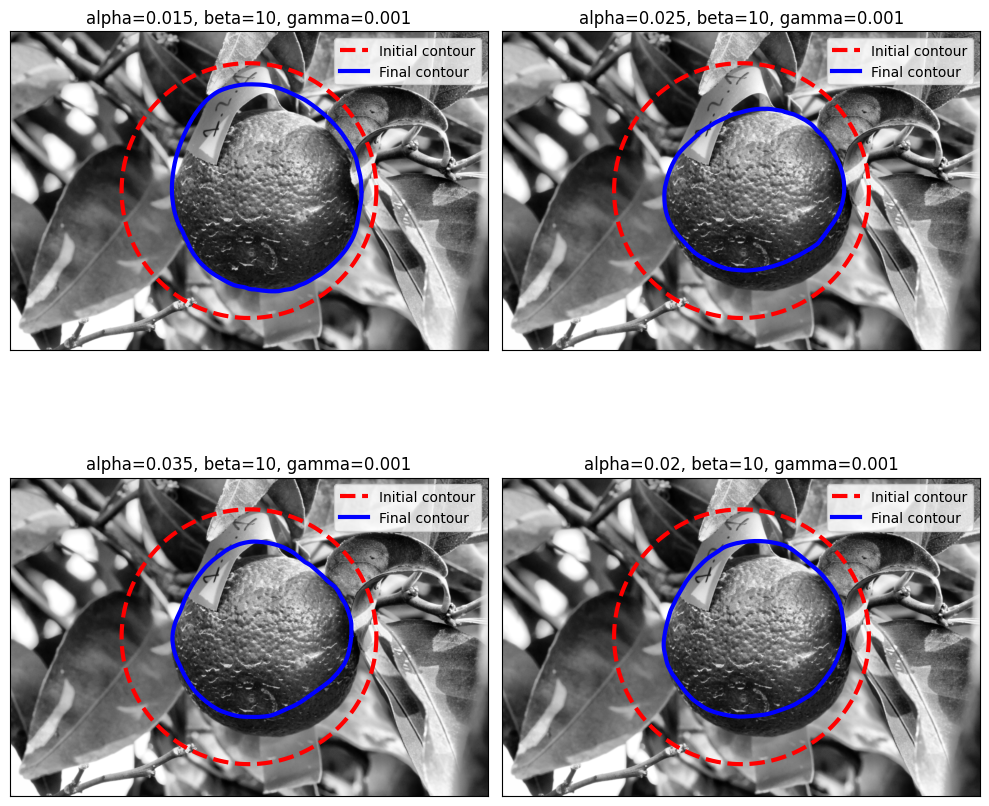

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.exposure import equalize_adapthist  # CLAHE
from skimage.segmentation import active_contour

# Define the active contour segmentation function
def segment_with_active_contour(image_path, alpha, beta, gamma):
    # Load the image
    img = imread(image_path)
    if img.ndim == 3:
        img = rgb2gray(img)

    # Enhance contrast using CLAHE
    img = equalize_adapthist(img)

    # Optionally resize for faster processing (optional)
    img = resize(img, (img.shape[0] // 8, img.shape[1] // 8))

    # Edge detection
    edges = sobel(img)

    # Initial contour (circle around the center)
    s = np.linspace(0, 2*np.pi, 200)
    x_center, y_center = img.shape[1] // 2, img.shape[0] // 2
    radius = (img.shape[0] * 0.8) / 2
    r = y_center + radius * np.sin(s)
    c = x_center + radius * np.cos(s)
    init = np.array([r, c]).T

    # Active contour model
    snake = active_contour(edges, init, alpha=alpha, beta=beta, gamma=gamma)

    return img, init, snake

# Different combinations of parameters
param_combinations = [
    (0.015, 10, 0.001),
    (0.025, 10, 0.001),
    (0.035, 10, 0.001),
    (0.02, 10, 0.001),
]

# Image path
image_path = '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231103/prediction/raw data/RGB/1D3A4803.JPG'

# Plotting results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for ax, params in zip(axes, param_combinations):
    alpha, beta, gamma = params
    img, init, snake = segment_with_active_contour(image_path, alpha, beta, gamma)

    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3, label='Initial contour')
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3, label='Final contour')
    ax.set_xticks([]), ax.set_yticks([])
    ax.legend()
    ax.set_title(f'alpha={alpha}, beta={beta}, gamma={gamma}')

plt.tight_layout()
plt.show()


grid on the image to find the approx size of the mandarin

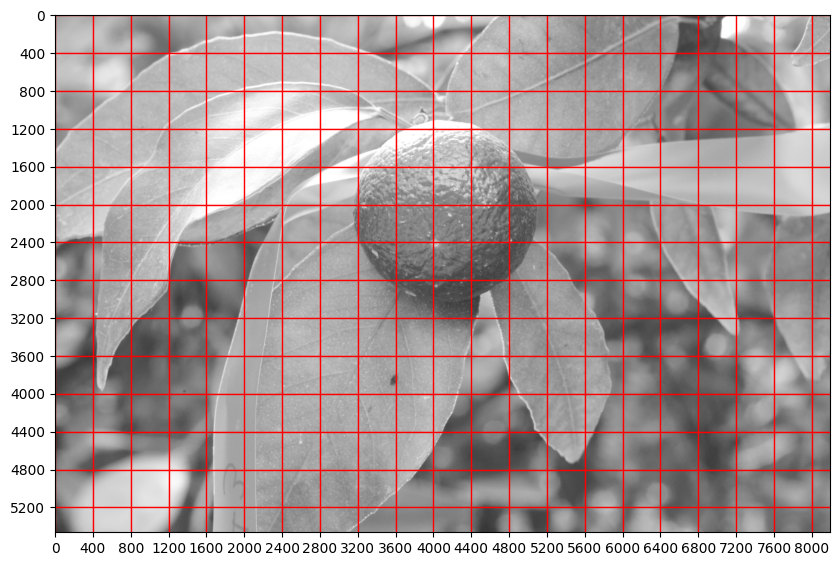

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray

# Function to add grids to an image
def add_grids_to_image(image, grid_size):
    h, w = image.shape[:2]
    for y in range(0, h, grid_size):
        cv2.line(image, (0, y), (w, y), (255, 0, 0), 1)  # Red color for grids
    for x in range(0, w, grid_size):
        cv2.line(image, (x, 0), (x, h), (255, 0, 0), 1)  # Red color for grids
    return image

# Path to the image
image_path = '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230825/Prediction/RGB/1D3A3157.JPG'

# Read the image
image = imread(image_path)
if image.ndim == 3:
    image = rgb2gray(image)

# Convert the image to RGB for displaying the grid
image_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# Add grids to the image
grid_size = 400  # Adjust this value as needed
image_with_grids = add_grids_to_image(image_rgb.copy(), grid_size)

# Display the image with grids and axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_with_grids)
ax.set_xticks(np.arange(0, image_with_grids.shape[1], grid_size))
ax.set_yticks(np.arange(0, image_with_grids.shape[0], grid_size))
ax.grid(color='r', linestyle='-', linewidth=1)
plt.show()


add performance measures (size of shape and how much the shape is circular)

Expected area range: 7068583.470577034 - 9079202.768874502


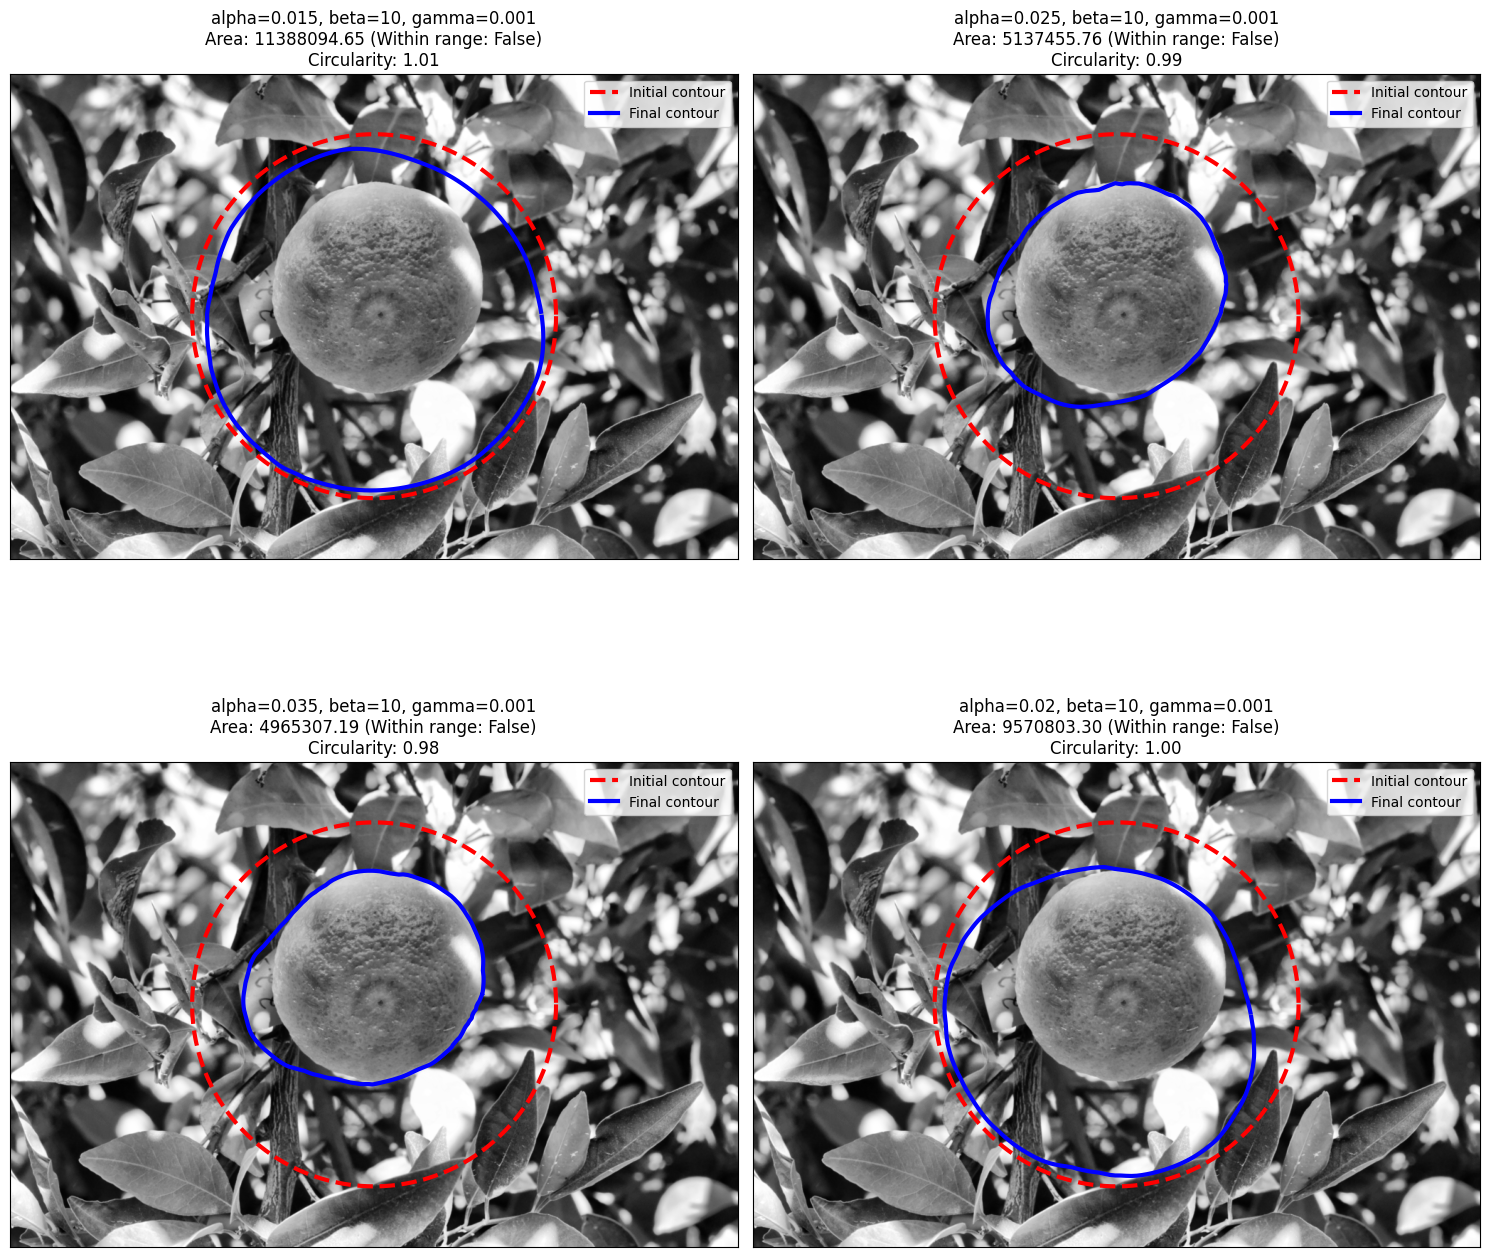

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.exposure import equalize_adapthist  # CLAHE
from skimage.segmentation import active_contour
from skimage.measure import find_contours, perimeter

# Define the active contour segmentation function
def segment_with_active_contour(image_path, alpha, beta, gamma):
    # Load the image
    img = imread(image_path)
    if img.ndim == 3:
        img = rgb2gray(img)

    # Enhance contrast using CLAHE
    img = equalize_adapthist(img)

    # Optionally resize for faster processing
    original_shape = img.shape
    img = resize(img, (img.shape[0] // 8, img.shape[1] // 8))

    # Edge detection
    edges = sobel(img)

    # Initial contour (smaller circle around the center)
    s = np.linspace(0, 2 * np.pi, 200)
    x_center, y_center = img.shape[1] // 2, img.shape[0] // 2
    radius = (img.shape[0] * 0.75) / 2  # Adjusted initial radius
    r = y_center + radius * np.sin(s)
    c = x_center + radius * np.cos(s)
    init = np.array([r, c]).T

    # Active contour model
    snake = active_contour(edges, init, alpha=alpha, beta=beta, gamma=gamma)

    return img, init, snake, original_shape

# Function to calculate the area of a contour
def contour_area(contour):
    x = contour[:, 0]
    y = contour[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Function to calculate the circularity of a contour
def contour_circularity(contour):
    area = contour_area(contour)
    perimeter_length = np.sum(np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1)))
    if perimeter_length == 0:
        return 0
    return 4 * np.pi * (area / (perimeter_length ** 2))

# Different combinations of parameters
param_combinations = [
    (0.015, 10, 0.001),
    (0.025, 10, 0.001),
    (0.035, 10, 0.001),
    (0.02, 10, 0.001),
]

# Image path
image_path = '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231216/prediction/raw data/RGB/1D3A5373.JPG'

# Define the expected area range based on the radius 1600 +- 100
radius_range = (1500, 1700)
expected_area_min = np.pi * (radius_range[0] ** 2)
expected_area_max = np.pi * (radius_range[1] ** 2)

# Print the expected area range
print(f'Expected area range: {expected_area_min} - {expected_area_max}')

# Plotting results
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for ax, params in zip(axes, param_combinations):
    alpha, beta, gamma = params
    img, init, snake, original_shape = segment_with_active_contour(image_path, alpha, beta, gamma)

    # Calculate performance measures
    detected_area = contour_area(snake)
    circularity = contour_circularity(snake)
    is_within_range = expected_area_min <= detected_area * 64 <= expected_area_max

    # Display the image with contours
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3, label='Initial contour')
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3, label='Final contour')
    ax.set_xticks([]), ax.set_yticks([])
    ax.legend()
    ax.set_title(f'alpha={alpha}, beta={beta}, gamma={gamma}\n'
                 f'Area: {detected_area * 64:.2f} (Within range: {is_within_range})\n'
                 f'Circularity: {circularity:.2f}')

plt.tight_layout()
plt.show()


# Calculate the size after masking

one image only

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

# Load the image
image_path = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/active_contour/active_contour_results/20231103/masked_1D3A4803.JPG'
image = imread(image_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Threshold the image to create a binary mask
thresh = threshold_otsu(gray_image)
binary_mask = gray_image < thresh  # Invert the mask since the background is white

# Calculate the size of the shape (number of pixels in the mask)
shape_size = np.sum(binary_mask)

# Plot the original image and the binary mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image')

ax[1].imshow(binary_mask, cmap=plt.cm.gray)
ax[1].set_title('Binary Mask')

plt.show()

print(f"Size of the shape: {shape_size} pixels")
